In [1]:

import torch
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import pandas as pd
import glob

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torchmetrics as tm

from config import Config
from dataset import *
from utils import DiceCELossSplitter, plot_img_label_pred, AggregateTestingResultsCallback
from transforms import ImageVisualizer
import wandb
import seaborn as sns

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)


Seed set to 99


99

In [2]:
# globally set source domains for SVDNA and for dataset preppning
cfg = Config(source_domains = ["Cirrus"])
cfg.batch_size = 1
cfg.epochs = 150

To change experimental setting, check the following:

- source domains in the OCTDatasetPrep class
- Turn on SVDNA in the config file

In [3]:
train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir,
                                                 source_domains = cfg.source_domains
                                                ).get_datasets(dataset_split=[0.8, 0.01, 0.1], use_official_testset=False)

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)


Total dataset length:  991
Training set: 792
Validation set: 9
Test set: 190


Spectralis: 465 images <br>
Topcon: 952 images <br>
Cirrus: 991 images

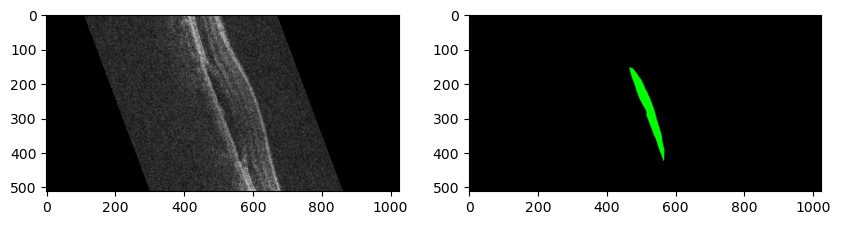

In [4]:
# randomly sample image
random_num = torch.randint(0, len(train_dataset), (1, ))
sample = train_dataset[random_num.item()]

img = sample['img']
mask = sample['masks']

#visualize images in subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0], cmap='gray')
ax[1].imshow(mask[1:].permute(1, 2, 0))
plt.show()

In [5]:
from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False

In [6]:
class LitUNetPlusPlus(L.LightningModule):
    def __init__(self, cfg, model, experiment_name):
        super().__init__()
        self.cfg = cfg

        self.save_hyperparameters()
        self.model = model
        self.experiment_name = experiment_name

        self.loss_func1 = monai.losses.GeneralizedDiceLoss(include_background=False, sigmoid=True)
        self.loss_func2 = torch.nn.BCEWithLogitsLoss()

        # several metrics
        avg = 'weighted' # weighted: calculates statistics for each label and computes weighted average using their support
        num_classes = 2
        task = 'binary'

        # validation
        self.val_accuracy = tm.classification.Accuracy(task=task, num_classes=num_classes)
        self.val_f1 = tm.classification.F1Score(task=task, num_classes=num_classes)
        self.val_precision = tm.classification.Precision(task=task, average=avg, num_classes=num_classes)
        self.val_recall = tm.classification.Recall(task=task, average=avg, num_classes=num_classes)
        self.val_specificity = tm.classification.Specificity(task=task, average=avg, num_classes=num_classes)

        # test
        self.test_accuracy = tm.classification.Accuracy(task=task, num_classes=num_classes)
        self.test_f1 = tm.classification.F1Score(task=task, num_classes=num_classes)
        self.test_precision = tm.classification.Precision(task=task, average=avg, num_classes=num_classes)
        self.test_recall = tm.classification.Recall(task=task, average=avg, num_classes=num_classes)
        self.test_specificity = tm.classification.Specificity(task=task, average=avg, num_classes=num_classes)


        self.results = {"Model": [], 
                        "Task": [], 
                        "Accuracy": [], 
                        "F1": [], 
                        "Precision": [], 
                        "Recall": [], 
                        "Specificity": []}
        
        self.tasks = ["Background", "IRF", "SRD", "PED"]

    def training_step(self, batch, batch_idx):
        inputs = batch['img']
        masks = batch['masks']

        outputs = self.model(inputs)

        dice_loss = self.loss_func1(outputs, masks)
        ce_loss = self.loss_func2(outputs, masks)
        total_loss = dice_loss + 0.5 * ce_loss

        self.log('train_loss_dice', dice_loss.item())
        self.log('train_loss_ce', ce_loss.item())
        self.log('train_loss_total', total_loss.item())

        return total_loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['img']
        masks = batch['masks']

        outputs = self.model(inputs)

        dice = self.loss_func1(outputs, masks)
        ce = self.loss_func2(outputs, masks)
        total_loss = dice + 0.5 * ce

        outputs_nobg = outputs[:, 1:, :, :]
        masks_nobg = masks[:, 1:, :, :]

        output_to_save = torch.sigmoid(outputs_nobg[:5])

        # thresholding
        output_to_save[output_to_save > 0.5] = 1
        output_to_save[output_to_save <= 0.5] = 0

        for i in range(output_to_save.shape[0]):
            img_path = os.path.join(cfg.validation_img_path, f"epoch{self.current_epoch}")
            if not os.path.isdir(img_path): os.mkdir(img_path)
            img = os.path.join(img_path, f"b{batch_idx}img{i+1}.png")
            cv2.imwrite(img, output_to_save[i].permute(1, 2, 0).cpu().numpy() * 255)

        self.log('val_loss_total', total_loss)
        self.log('val_loss_dice', dice)
        self.log('val_loss_ce', ce)

        self.log('val_accuracy', self.val_accuracy(outputs_nobg, masks_nobg.long()))
        self.log('val_f1', self.val_f1(outputs_nobg, masks_nobg.long()))
        self.log('val_precision', self.val_precision(outputs_nobg, masks_nobg.long()))
        self.log('val_recall', self.val_recall(outputs_nobg, masks_nobg.long()))
        self.log('val_specificity', self.val_specificity(outputs_nobg, masks_nobg.long()))

        return total_loss
    
    def test_step(self, batch, batch_idx):
        inputs = batch['img']
        masks = batch['masks']

        outputs = self.model(inputs)

        dice = self.loss_func1(outputs, masks)
        ce = self.loss_func2(outputs, masks)
        total_loss = dice + 0.5 * ce

        self.log('test_loss_dice', dice)
        self.log('test_loss_ce', ce)
        self.log('test_loss_total', total_loss)

        torch.sigmoid_(outputs)

        # calculate metrics for each channel and record separately in pandas df
        for channel in range(outputs.shape[1]):

            outputs_channel = outputs[:, channel, :, :]
            masks_channel = masks[:, channel, :, :]

            accuracy = self.test_accuracy(outputs_channel, masks_channel)
            f1 = self.test_f1(outputs_channel, masks_channel)
            precision = self.test_precision(outputs_channel, masks_channel)
            recall = self.test_recall(outputs_channel, masks_channel)
            specificity = self.test_specificity(outputs_channel, masks_channel)

            self.results["Model"].append(self.experiment_name)
            self.results["Task"].append(self.tasks[channel])
            self.results["Accuracy"].append(accuracy.item())
            self.results["F1"].append(f1.item())
            self.results["Precision"].append(precision.item())
            self.results["Recall"].append(recall.item())
            self.results["Specificity"].append(specificity.item())
        
        return total_loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=self.cfg.factor, patience=self.cfg.patience_lr)
        return {"optimizer": optimizer, 
                "lr_scheduler": {'scheduler': scheduler, 'monitor': 'val_loss_total'}}
    
    def forward(self, x):
        return self.model(x)
    



############################################################################
experiment_name = "spectralis_tinytest"

wandb_logger = WandbLogger(project="PracticalWorkinAI", name="trial")
############################################################################



model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)
    
unetpp = LitUNetPlusPlus(cfg, model, experiment_name=experiment_name)



checkpoint_callback = ModelCheckpoint(dirpath=cfg.model_path / experiment_name, 
                                      monitor='val_loss_total', 
                                      mode='min',
                                      filename='{experiment_name}-{epoch:02d}-{val_loss_total:.3f}-{val_precision:.3f}',
                                      every_n_epochs=5,
                                      save_top_k=3,
                                      verbose=True)

early_stopping = EarlyStopping(monitor='val_loss_total', mode='min', patience=cfg.early_stopping_patience)

lr_monitor = LearningRateMonitor(logging_interval='step')

aggregate_testing_results = AggregateTestingResultsCallback()

trainer = L.Trainer(max_epochs=cfg.epochs, 
                    accumulate_grad_batches=8,
                    logger=wandb_logger,
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=10,
                    callbacks=[checkpoint_callback, 
                               lr_monitor, 
                               #early_stopping,
                               aggregate_testing_results],
                    deterministic=True)

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
#trainer.test(unetpp, dataloaders=test_loader)
#wandb.finish

In [7]:
model_checkpoints = os.listdir("models")
print(model_checkpoints)

['spectralis-no-svdna-epoch=139-val_loss_total=0.302-val_precision=0.851.ckpt', 'supervised-epoch=134-val_loss_total=0.26-val_precision=0.85.ckpt', 'initial_model.ckpt', 'spectr-epoch=139-val_loss_total=0.29-val_precision=0.84.ckpt']


In [11]:
# load best checkpoint 

model_eval = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = Path('models') / model_checkpoints[3], experiment_name=experiment_name)

trainer = L.Trainer(max_epochs=cfg.epochs, 
                    logger=wandb_logger,
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=10,
                    callbacks=[checkpoint_callback, 
                               lr_monitor, 
                               #early_stopping,
                               aggregate_testing_results],
                    deterministic=True)

trainer.test(model_eval, dataloaders=val_loader)
wandb.finish()

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.4
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

+------------+---------------------+--------------------+---------------------+---------------------+---------------------+--------------------+
|    Task    |        Model        |      Accuracy      |         F1          |      Precision      |       Recall        |    Specificity     |
+------------+---------------------+--------------------+---------------------+---------------------+---------------------+--------------------+
| Background | spectralis_tinytest | 0.9800688425699869 |  0.989703721470303  |  0.987110263771481  | 0.9927139282226562  | 0.6407234229975276 |
|    IRF     | spectralis_tinytest | 0.9914126925998263 | 0.3775755597485436  | 0.37550507651435006 | 0.46326103806495667 | 0.9947644273440043 |
|    PED     | spectralis_tinytest | 0.9989140828450521 | 0.13011115127139622 | 0.12865017520056832 | 0.1382349729537964  | 0.9994520478778415 |
|    SRD     | spectralis_tinytest | 0.9895659552680122 | 0.14345852751284838 | 0.2517116732067532  | 0.16775544898377526 | 0.9995

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁
test_loss_ce,▁
test_loss_dice,▁
test_loss_total,▁
trainer/global_step,▁
epoch,0
test_loss_ce,0.05321
test_loss_dice,0.53984
test_loss_total,0.56645
trainer/global_step,0


## Visualization and results

### Visualize some images and masks

In [8]:
print_some_imgs = False

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




### Load model and make predictions on random images from validation set

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.4
/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


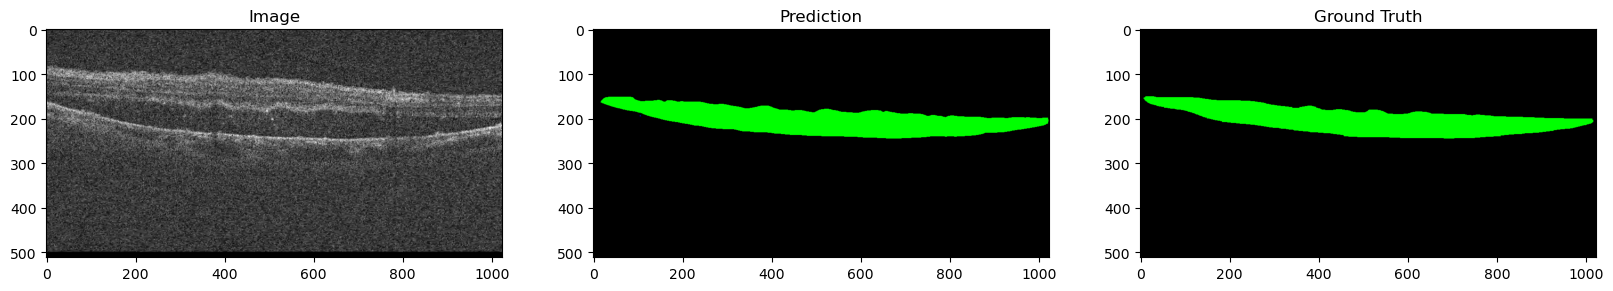

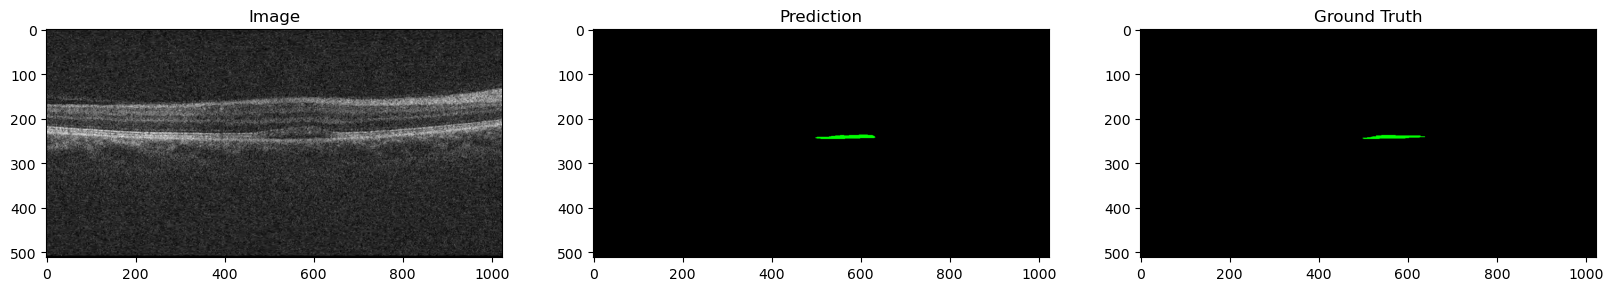

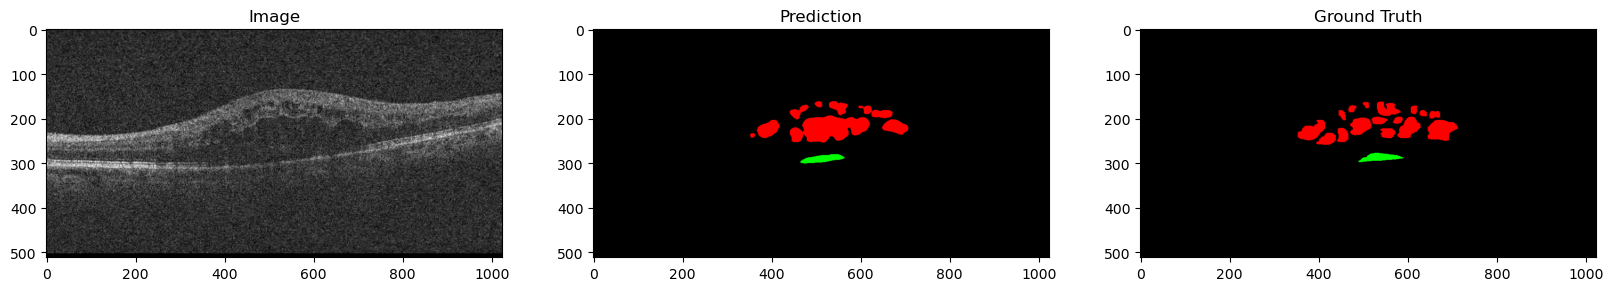

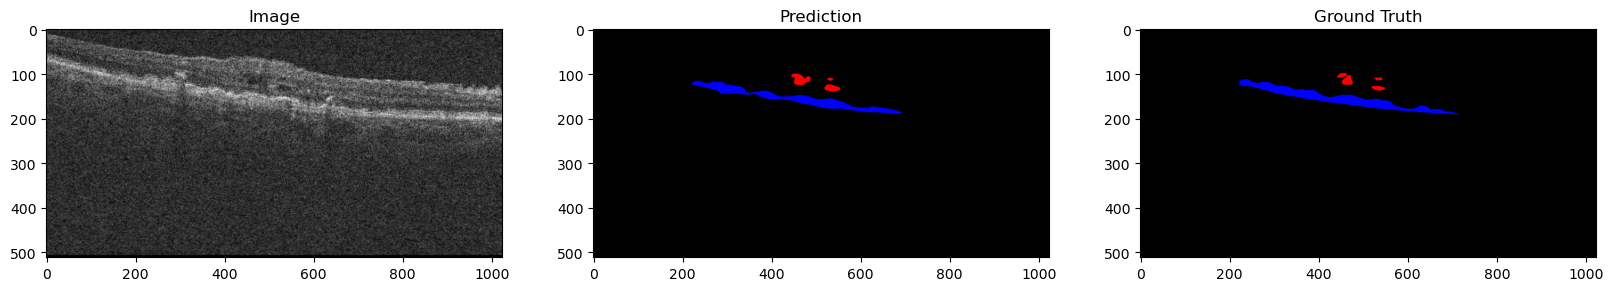

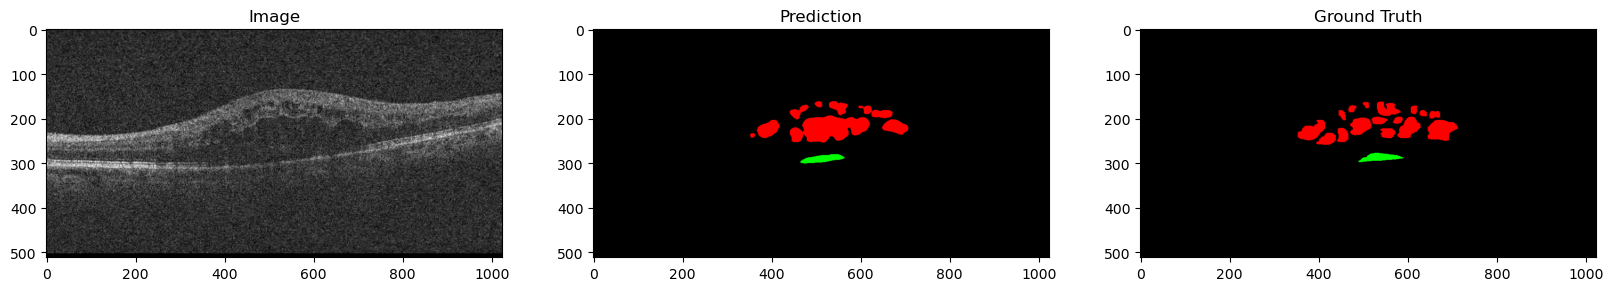

In [75]:
get_predictions = True

if get_predictions:
    model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[1])
    model.eval()

    for i in range(np.min([5, len(val_dataset)])):
        rand_num = np.random.randint(0, len(val_dataset))
        sample = val_dataset[rand_num]

        img = sample['img'].unsqueeze(0)
        mask = sample['masks'].unsqueeze(0)

        pred = model(img)
        pred = torch.sigmoid(pred)
        
        # thresholding
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0

        plot_img_label_pred(img, pred, mask)

## Create results tables from saved csv

In [74]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = [file for file in os.listdir(results_folder) if file.startswith("results_raw_") and file.endswith(".csv")]

# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)

means = result.groupby(["Task", "Model"]).mean().round(3)
stds = result.groupby(["Task", "Model"]).std().round(3)

# combine the two dataframes such that the result has "mean (std)" format
result = means.astype(str) + " (" + stds.astype(str) + ")" 

# tabulate
print(tabulate(result, headers='keys', tablefmt='fancy_grid'))
result.to_latex("results.tex")


╒═══════════════════════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│                                       │ Accuracy      │ F1            │ Precision     │ Recall        │ Specificity   │
╞═══════════════════════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ ('Background', 'spectralis_tinytest') │ 0.98 (0.024)  │ 0.99 (0.012)  │ 0.987 (0.026) │ 0.993 (0.007) │ 0.641 (0.298) │
├───────────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ ('Background', 'supervised_tinytest') │ 0.993 (0.004) │ 0.996 (0.002) │ 0.997 (0.002) │ 0.996 (0.002) │ 0.768 (0.118) │
├───────────────────────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ ('Background', 'trial')               │ 0.026 (0.025) │ 0.008 (0.005) │ 0.969 (0.043) │ 0.004 (0.003) │ 0.995 (0.007) │
├───────────────────────

['trial', 'spectralis_tinytest', 'supervised_tinytest']


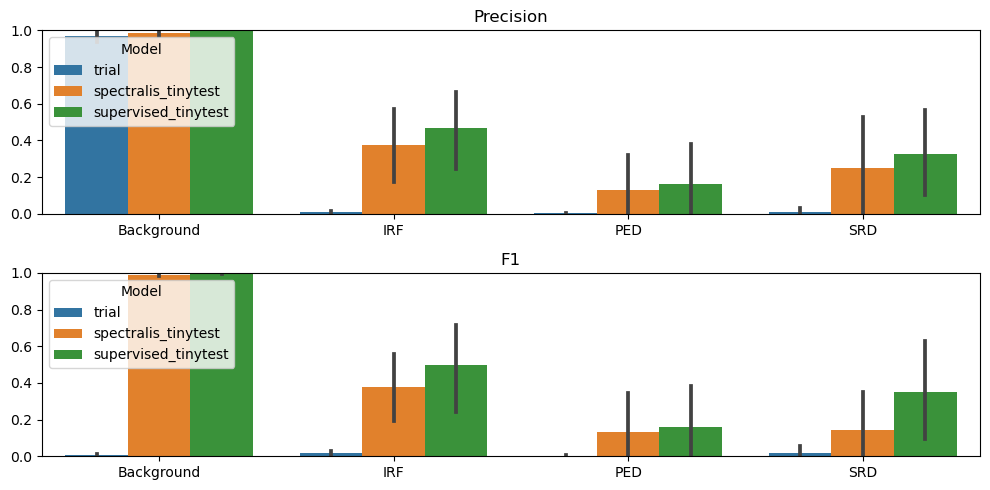

In [45]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = [file for file in os.listdir(results_folder) if file.startswith("results_raw_") and file.endswith(".csv")]

# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)


# melt the dataframe
result_melted = pd.melt(result, id_vars=["Model", "Task"], value_vars=["Accuracy", "F1", "Precision", "Recall", "Specificity"], var_name="Metric")

# create 2 subplots, one for each metric
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

# Get a sorted list of unique model names, with "trials" first
task_order = sorted(result_melted["Task"].unique())
model_order = sorted(result_melted["Model"].unique())
model_order.insert(0, model_order.pop(model_order.index('trial')))
print(model_order)

# Only plot Precision and F1
for i, metric in enumerate(["Precision", "F1"]):
    data = result_melted[result_melted["Metric"] == metric]
    data = data.sort_values('value', ascending=True)  # sort the data by value

    # Pass the model_order list to the order parameter
    sns.barplot(data=data, x="Task", y="value", hue="Model", ax=axes[i], order=task_order, hue_order=model_order)

    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].legend(loc='upper left', title="Model")

plt.tight_layout()
plt.show()